In [60]:
import preprocessing as prep
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
from datetime import datetime, timedelta, time
import glob
from generate_atmosphere import LidarProfile,RadiosondeProfile
import miscLidar as mscLid
from molecular import rayleigh_scattering
import global_settings as gs
import pandas as pd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import xarray as xr
from IPython.display import display
%matplotlib inline
import torch,torchvision
import torch.utils.data

In [61]:
import torch, torchvision
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU
    return device

device = get_device()

In [62]:
class customDataSet ( torch.utils.data.Dataset ) :
    """TODO"""

    def __init__ ( self , csv_file,
                   top_height = 15.0 ,
                   powers= {'range_corr':0.5 , 'attbsc':0.5 ,
                             'LC': 0.5, 'LC_std': 0.5 ,
                             'r0': 1 , 'r1': 1 }) :
        """
        Args:
            csv_file (string): Path to the csv file of the database.
        """
        self.data = pd.read_csv(csv_file)
        self.key = [ 'date' , 'wavelength' , 'cali_method' , 'telescope' , 'cali_start_time' , 'cali_stop_time' ,
                     'start_time_period' , 'end_time_period' ]
        self.Y_features = [ 'LC','r0','r1' ] #, 'LC_std'
        self.X_features = [ 'lidar_path' , 'molecular_path' ]
        self.profiles =   ['range_corr', 'attbsc']
        self.X_powers =    [powers[profile] for profile in self.profiles]
        self.Y_powers =   [powers[feature] for feature in self.Y_features]
        self.top_height = top_height

    def __len__ ( self ) :
        return len ( self.data )

    def __getitem__ ( self , idx ) :
	    # load data
	    row = self.data.loc [ idx , : ]
	    X_paths = row[self.X_features]
	    datasets = [prep.load_dataset(path) for path in X_paths]

	    # Calc sample height and time slices
	    hslices  = [slice(ds.Height.min().values.tolist(),ds.Height.min().values.tolist()+self.top_height)
                    for ds in datasets]
	    tslice = slice ( row.start_time_period , row.end_time_period )

	    # Get sample
	    X_ds = [ds.sel( Time = tslice , Height = hslice)[profile]
             for ds,profile,hslice in zip(datasets,profiles,hslices)]
	    Y_ds = row [self.Y_features ]

	    # transform the sample (trim negative and gamma correction)
	    USE_POW = False
	    if USE_POW:
		    X_ds = self.pow_X(X_ds)
		    Y_ds = self.pow_Y(Y_ds)

	    # convert to tensors
	    X = torch.dstack((torch.from_numpy(X_ds[0].values),
	                      torch.from_numpy(X_ds[1].values))).permute(2, 0, 1)
	    Y = torch.from_numpy(np.array(Y_ds))
	    return {'x':X,'y':Y}

    def pow_X (self, X):
	    # trim negative values
	    X =[x_i.where(x_i>=0, np.finfo(np.float).eps) for x_i in X ]
	    # apply power
	    X = [xr.apply_ufunc(lambda x: x**pow, x_i, keep_attrs=True)
	                for (pow,x_i) in zip(self.X_powers,X)]
	    return X
    def pow_Y (self, Y):
	    return [y_i**pow for (pow,y_i) in zip(self.Y_powers,Y)]


In [63]:
start_date = datetime ( 2017 , 9 , 1 )
end_date = datetime ( 2017 , 10 , 31)
csv_path = f"dataset_{start_date.strftime('%Y-%m-%d')}_{end_date.strftime('%Y-%m-%d')}.csv"
dataloader = torch.utils.data.DataLoader ( csv_path , batch_size = 4 ,
                                           shuffle = True )


for i_batch , sample_batched in enumerate ( dataloader ) :
    print ( i_batch , sample_batched )


0 ['7', '1', '-', '0']
1 ['2', '7', '0', 'c']
2 ['d', '.', '3', '_']
3 ['t', '1', 's', '1']
4 ['0', '_', 'a', '-']
5 ['s', 'v', '0', '2']
6 ['a', '9', '1', '-']
7 ['e', 't', '0', '1']
8 ['-']


In [ ]:
dataset = pd.read_csv(csv_path)
dataset
top_height = 15.0 # km top height to perform calibration.

powers= {'range_corr':0.5, 'attbsc': 0.5 ,
          'LC': 0.5, 'LC_std': 0.5 ,
          'r0': 1 , 'r1': 1 }
data = pd.read_csv(csv_path)
key = [ 'date' , 'wavelength' , 'cali_method' , 'telescope' , 'cali_start_time' , 'cali_stop_time' ,
             'start_time_period' , 'end_time_period' ]
Y_features = [ 'LC' , 'LC_std' , 'r0','r1' ]
X_features = [ 'lidar_path' , 'molecular_path' ]
profiles =   ['range_corr', 'attbsc']
#X_scales = [scales[profile] for profile in profiles]
X_powers =   [powers[profile] for profile in profiles]
#Y_scales =   [scales[feature] for feature in Y_features]
Y_powers =   [powers[feature] for feature in Y_features]

In [5]:
idx = 1400
row = data.loc [ idx , : ]
row

15.0

In [7]:
X_paths = row[X_features]
datasets = [prep.load_dataset(path) for path in X_paths]
#datasets[0]

In [8]:
hslices  = [slice(ds.Height.min().values.tolist(),
                  ds.Height.min().values.tolist()+top_height)
            for ds in datasets]
tslice = slice ( row.start_time_period , row.end_time_period )
print(hslices, tslice)

[slice(0.30875, 15.30875, None), slice(0.30875, 15.30875, None)] slice('2017-10-05 04:30:00', '2017-10-05 04:59:30', None)


In [13]:
def scale_X (X, scales,units_s = ['km','km']): # x - xr.dataset, self.X_scales
	X = [xr.apply_ufunc(lambda x: x*scale, x_i, keep_attrs=True)
                for (scale,x_i) in zip(scales,X)]
	for x_i in X:
		x_i.attrs["units"]= x_i.units.replace(units_s[0],units_s[1])
	return  X

def pow_X (X, powers): # self.X_powers
	X = [xr.apply_ufunc(lambda x: x**pow, x_i, keep_attrs=True)
                for (pow,x_i) in zip(powers,X)]
	return X

def scale_Y (Y, scales): # self.Y_scales
	return [y_i*scale for (scale,y_i) in zip(scales,Y)]

def pow_Y (Y ,powers): # self.Y_powers
	return [y_i**pow for (pow,y_i) in zip(powers,Y)]


Sample no. 1400:
Y: [32702.942858488568, 40.19667223820085, 2.417317138671875, 3.9116091308593752]
Displaying X below
Trimming negative values
Following power transform of:
X powers: [0.5, 0.5],
Y powers: [0.5, 0.5, 1, 1]
Y:[180.8395500394993, 6.340084560808385, 2.417317138671875, 3.9116091308593752]


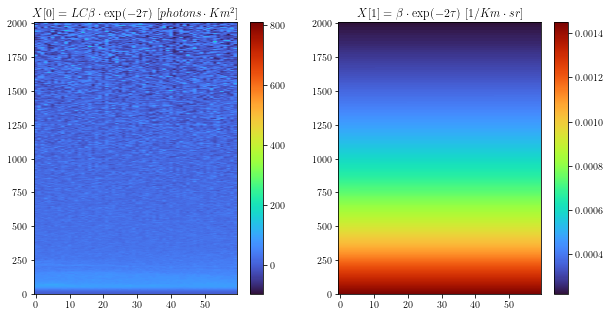

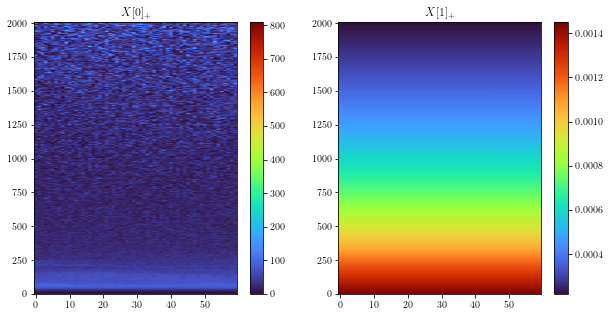

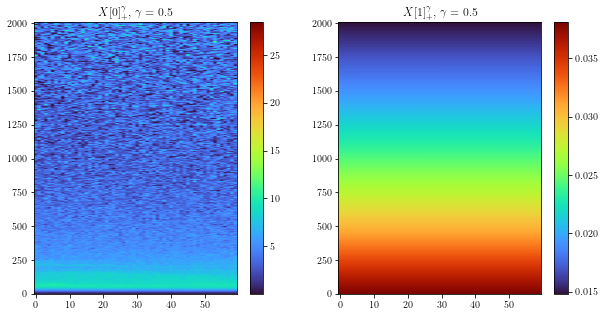

In [35]:
# show sample
X = [ds.sel( Time = tslice , Height = hslice)[profile]
     for ds,profile,hslice in zip(datasets,profiles,hslices)]
Y = row[Y_features].tolist()

print(f"Sample no. {idx}:")
print(f"Y: {Y}")
print(f"Displaying X below")
# Show sample (before conversion to pytorch)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
for ind,(ax_i, x_i, profile) in enumerate(zip(axes.flatten(),X,profiles)):
	im = ax_i.imshow(x_i ,
	           vmin=x_i.min().item(),
	           vmax= x_i.max().item(),
	           cmap = 'turbo',aspect='auto')
	ax_i.set_title(f"$X[{ind}] = $ {x_i.long_name} [{x_i.units}]")
	ax_i.invert_yaxis()
	fig.colorbar(im , ax=ax_i)

plt.show()

print('Trimming negative values')
X_pos =[x_i.where(x_i>=0, np.finfo(np.float).eps) for x_i in X ]
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
for ind, (ax_i, x_i, profile) in enumerate(zip(axes.flatten(),X_pos,profiles)):
	im = ax_i.imshow(x_i ,
	           vmin=x_i.min().item(),
	           vmax= x_i.max().item(),
	           cmap = 'turbo',aspect='auto')
	ax_i.set_title(f"$X[{ind}]_+$")
	ax_i.invert_yaxis()
	fig.colorbar(im , ax=ax_i)
plt.show()

print(f"Following power transform of:\nX powers: {X_powers},\nY powers: {Y_powers}")
X_powtran = pow_X(X_pos,X_powers)
Y_powtran = pow_Y(Y, Y_powers)
print(f"Y:{Y_powtran}")
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
for ind, (ax_i, x_i, powx) in enumerate(zip(axes.flatten(),X_powtran,X_powers)):
	im = ax_i.imshow(x_i ,
	           vmin=x_i.min().item(),
	           vmax= x_i.max().item(),
	           cmap = 'turbo',aspect='auto')
	ax_i.set_title(f"$X[{ind}]_+ ^\gamma$,  $\gamma = {powx}$")
	ax_i.invert_yaxis()
	fig.colorbar(im , ax=ax_i)
plt.show()

Histograms


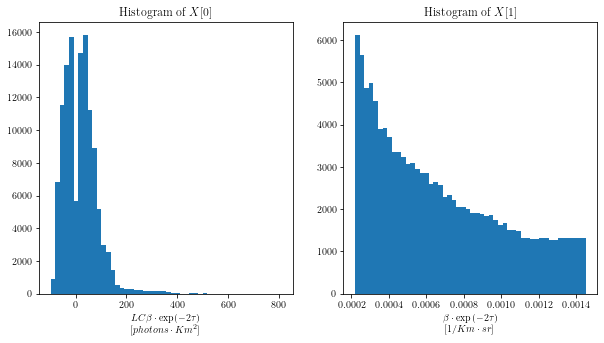

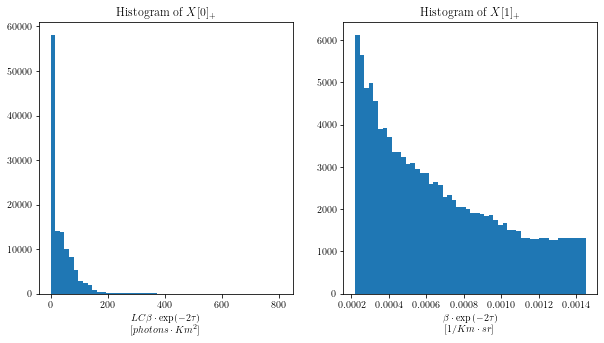

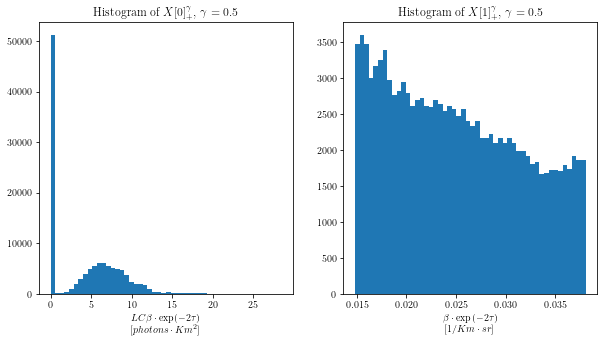

In [36]:
print('Histograms')
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
for ind,(ax_i, x_i, profile) in enumerate(zip(axes.flatten(),X,profiles)):
	x_i = x_i.rename(f"{profile.replace('_',' ')}")
	xr.plot.hist(x_i, ax = ax_i,bins = 50)
	ax_i.set_title(f"Histogram of $X[{ind}]$")
plt.show()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
for ind,(ax_i, x_i, profile) in enumerate(zip(axes.flatten(),X_pos,profiles)):
	x_i = x_i.rename(f"{profile.replace('_',' ')}")
	xr.plot.hist(x_i, ax = ax_i,bins = 50)
	ax_i.set_title(f"Histogram of $X[{ind}]_+$")
plt.show()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
for ind, (ax_i, x_i, profile,powx) in enumerate(zip(axes.flatten(),X_powtran,profiles,X_powers)):
	x_i = x_i.rename(f"{profile.replace('_',' ')}")
	xr.plot.hist(x_i.where(x_i>0), ax = ax_i,bins = 50)
	ax_i.set_title(f"Histogram of $X[{ind}]_+ ^\gamma$,  $\gamma = {powx}$")
plt.show()

In [47]:
X_np = np.dstack((X[0].values, X[1].values))
X_np.shape
X_torch = torch.from_numpy(X_np)
X_torch.shape

torch.Size([2008, 60, 2])

In [54]:
Xtorch = torch.dstack((torch.from_numpy(X[0].values),torch.from_numpy(X[1].values))).permute(2, 0, 1)
Xtorch.shape
Ytorch = torch.from_numpy(np.array(Y))
Ytorch

tensor([3.2703e+04, 4.0197e+01, 2.4173e+00, 3.9116e+00], dtype=torch.float64)

In [ ]:
'''
Xtensor = torch.from_numpy(sub_ds.values).float().to(device)
print(type(Xtensor), Xtensor.shape)
from PIL import Image
plt.figure()
plt.imshow(Xtensor.cpu() ,#torchvision.transforms.ToPILImage()(Xtensor),
           vmin=Xtensor.min().item(),
           vmax= Xtensor.max().item(),  cmap = 'turbo',aspect='auto')#, interpolation="bicubic")
plt.gca().invert_yaxis()
plt.colorbar()
#tensor_image = Xtensor.view(Xtensor.shape[0], Xtensor.shape[1])

plt.show()
'''